In [8]:
# %pip install --upgrade langchain langsmith langgraph langchain_openai openai python-dotenv javascript numpy genson
%reload_ext autoreload
%autoreload 2

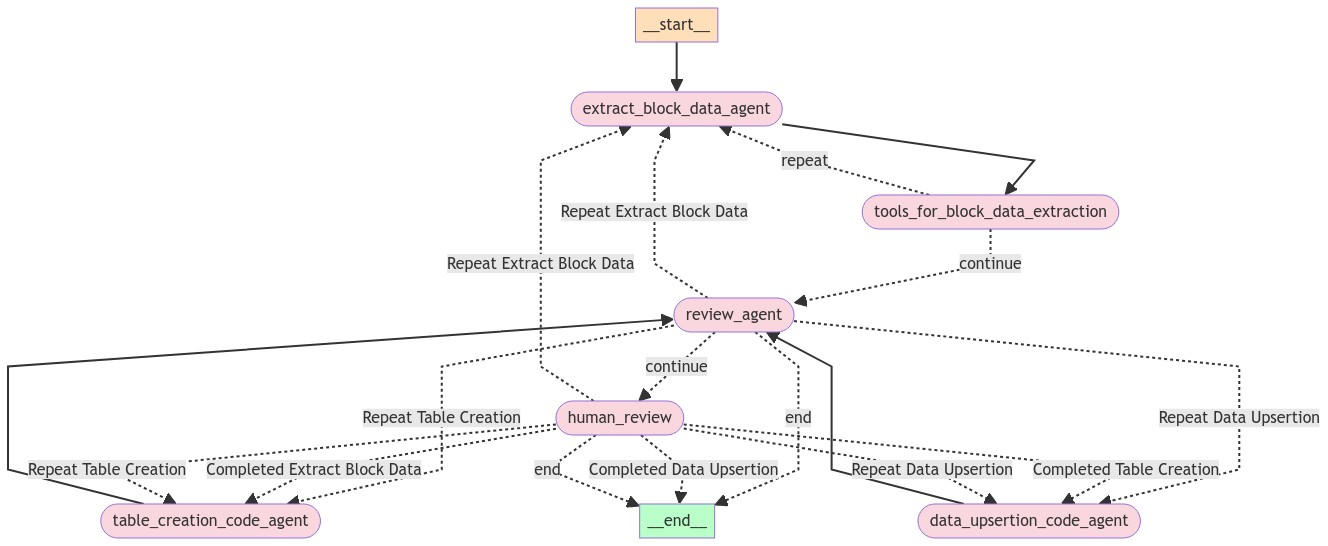

In [9]:
# Setup
from dotenv import load_dotenv
import os
from graph.master_graph import create_graph
from IPython.display import Image, display

# Load .env file
load_dotenv('.env')

# Set model variables
OPENAI_BASE_URL = "https://api.openai.com/v1"
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_ORGANIZATION = os.getenv("OPENAI_ORGANIZATION")

# Set environment variables
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")

# Create Graph
workflow = create_graph()
app = workflow.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [10]:
# Define question and invoke app
from langchain_core.messages import HumanMessage

question = """
    Extract all FunctionCalls where receiverId is 'app.nearcrowd.near'. For each function call, I need signerId, block height, receiptId, block datetime, methodName. 
    Also add all fields from args that are decoded from base64-encoded JSON. I only need actions for successful receipts. 
    Use block height 119688212 for parsing the JS code, and only pull data from the last 2 days.
    """

inputs = {
    "messages":[HumanMessage(content=question)],
    "block_schema": "",
    "block_heights":[], # TO DO: Add in block height logging
    "extract_block_data_code":"",
    "table_creation_code":"",
    "data_upsertion_code": "",
    "indexer_logic":"",
    "iterations": 0,
    "error":"",
    "should_continue": False,
    }

# RUN MASTER APP
result = app.invoke(inputs)
table_creation_code = result['table_creation_code'].replace("\\n","\n")
extract_block_data_code = result['extract_block_data_code'].replace("\\n","\n")
data_upsertion_code = result['data_upsertion_code'].replace("\\n","\n")
indexer_logic = result['indexer_logic'].replace("\\n","\n")

Calling tool: tool_js_on_block_schema_func
Calling tool: tool_infer_schema_of_js
Getting block heights from bitmap indexer for receiver=app.nearcrowd.near from_days_ago=2 limit=10
Inferring schema for return extractData(block); on block height 120454329
Reviewing code...
Code is not valid. Repeating: Extract Block Data.
Calling tool: tool_js_on_block_schema_func
Reviewing code...
Block Schema: {'type': 'array'}
Calling tool: tool_js_on_block_schema_func
Reviewing code...
Block Schema: {'type': 'array', 'items': {'type': 'object', 'properties': {'signerId': {'type': 'string'}, 'blockHeight': {'type': 'integer'}, 'receiptId': {'type': 'string'}, 'blockDatetime': {'type': 'string'}, 'methodName': {'type': 'string'}, 'task_ordinal': {'type': 'integer'}, 'task_hash': {'type': 'array', 'items': {'type': 'integer'}}}}}
Generating Table Creation Code
Reviewing code...
Generating Data Upsertion Code
Reviewing code...


In [11]:
print(f'SQL DDL: {table_creation_code}')
print(f'Data Upsertion Logic: {data_upsertion_code}')

SQL DDL: CREATE TABLE block_results (
    signer_id VARCHAR(255),
    block_height INTEGER,
    receipt_id VARCHAR(255) PRIMARY KEY,
    block_datetime TIMESTAMP,
    method_name VARCHAR(255),
    task_ordinal INTEGER,
    task_hash INTEGER[]
);
Data Upsertion Logic: async function upsertBlockResults(block) {
  const results = extractData(block);
  if (results.length === 0) return;

  const upsertData = results.map(result => ({
    signer_id: result.signerId,
    block_height: result.blockHeight,
    receipt_id: result.receiptId,
    block_datetime: result.blockDatetime,
    method_name: result.methodName,
    task_ordinal: result.task_ordinal,
    task_hash: result.task_hash
  }));

  try {
    await context.db.BlockResults.upsert(upsertData, ['receipt_id'], ['signer_id', 'block_height', 'block_datetime', 'method_name', 'task_ordinal', 'task_hash']);
    console.log('Data upserted successfully');
  } catch (error) {
    console.error('Error upserting data:', error);
  }
}

function ex